# Using Keras + Tensorflow to illustrate nonlinear multi-output regression

This notebook illustrates how to perform multi-output regression using `Keras` + `Tensorflow`.  In particular it illustrates how to 

- construct an arbitrary fully connected network / multilayer perceptron with the proper input / output dimensions

- run an RMSprop optimizer to tune paramters correctly

- how to plot a cost function history plot to ensure that optimization is running smoothly


Two datasets with input dimension / output dimension 2 are used in the illustration.

In [1]:
# import gridworld library - make sure this is executed prior to running any gridworld cell
import sys
sys.path.append('../')
import autograd.numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Utility functions for plotting

In [2]:
 def plot_data(x,y):
    # construct panels
    fig = plt.figure(figsize = (9,4))
    ax0 = plt.subplot(121,projection='3d')
    ax0.view_init(25,45)
    ax0.axis('off')

    ax1 = plt.subplot(122,projection='3d')
    ax1.view_init(25,45)
    ax1.axis('off')

    # scatter plot data in each panel
    ax0.scatter(x[0,:],x[1,:],y[0,:],c='k',edgecolor = 'w',linewidth = 1,s=60)
    ax1.scatter(x[0,:],x[1,:],y[1,:],c='k',edgecolor = 'w',linewidth = 1,s=60)
    plt.show()

In [3]:
def plot_regressions(x,y,model):
    # import all the requisite libs
    # construct panels
    fig = plt.figure(figsize = (9,4))
    ax0 = plt.subplot(121,projection='3d')
    ax0.view_init(25,45)
    ax0.axis('off')

    ax1 = plt.subplot(122,projection='3d')
    ax1.view_init(25,45)
    ax1.axis('off')

    # scatter plot data in each panel
    ax0.scatter(x[0,:],x[1,:],y[0,:],c='k',edgecolor = 'w',linewidth = 1,s=60)
    ax1.scatter(x[0,:],x[1,:],y[1,:],c='k',edgecolor = 'w',linewidth = 1,s=60)

    # construct input for each model fit
    a_ = np.linspace(0,1,10)
    a,b = np.meshgrid(a_,a_)
    a = a.flatten()[np.newaxis,:]
    b = b.flatten()[np.newaxis,:]
    c = np.vstack((a,b))

    # evaluate model 
    p = model.predict(c.T).T
    m1 = p[0,:]
    m2 = p[1,:]

    # plot each as surface
    a.shape = (a_.size,a_.size)
    b.shape = (a_.size,a_.size)
    m1.shape = (a_.size,a_.size)
    m2.shape = (a_.size,a_.size)

    ax0.plot_surface(a,b,m1,alpha = 0.1,color = 'lime',cstride = 2,rstride = 2,linewidth = 1,edgecolor ='k')
    ax1.plot_surface(a,b,m2,alpha = 0.1,color = 'lime',cstride = 2,rstride = 2,linewidth = 1,edgecolor ='k')

    plt.show()

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

#### compare cost function histories ####
def plot_cost_history(cost_history,start):        
    # initialize figure
    fig = plt.figure(figsize = (10,3))

    # create subplot with 1 panel
    gs = gridspec.GridSpec(1, 1) 
    ax = plt.subplot(gs[0]); 

    # plot train cost function history
    ax.plot(np.arange(start,len(cost_history),1),cost_history[start:],linewidth = 3*(0.8)**(1),label = 'train cost') 

    # clean up panel / axes labels
    xlabel = 'step $k$'
    ylabel = r'$g\left(\mathbf{w}^k\right)$'
    ax.set_xlabel(xlabel,fontsize = 14)
    ax.set_ylabel(ylabel,fontsize = 14,rotation = 0,labelpad = 25)
    title = 'train histories'
    ax.set_title(title,fontsize = 18)

    # plot legend
    anchor = (1,1)
    plt.legend(loc='upper right', bbox_to_anchor=anchor)
    ax.set_xlim([start - 0.5,len(cost_history) - 0.5]) 
    plt.show()

# Example multi-output datasets

<IPython.core.display.Javascript object>


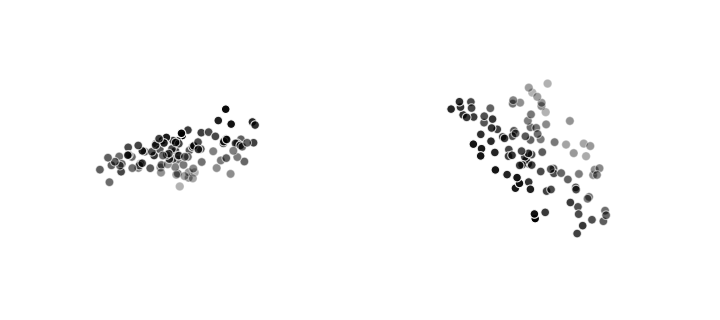

In [5]:
# load in data
csvname = '../datasets/linear_2output_regression.csv'
linear_data = np.loadtxt(csvname,delimiter=',')
x_lin = linear_data[:2,:]
y_lin = linear_data[2:,:]

# plot
plot_data(x_lin,y_lin)

<IPython.core.display.Javascript object>


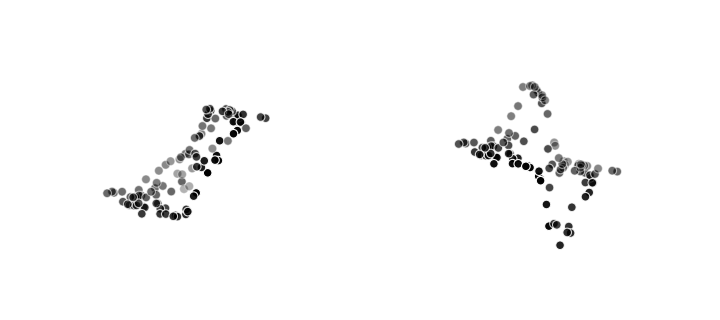

In [6]:
# load in data
csvname = '../datasets/nonlinear_2output_regression.csv'
nonlinear_data = np.loadtxt(csvname,delimiter=',')
x_nonlin = nonlinear_data[:2,:]
y_nonlin = nonlinear_data[2:,:]

# plot
plot_data(x_nonlin,y_nonlin)

# Setup network architecture

In [7]:
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Sequential

'''
A generic function for building network architectures for multi-output regression.
Input/output data is used to size the input / output layers of the network.  All other 
parameters - e.g., num layers, layer sizes, optimizer, learning rate have default settings
or can be changed by user.
'''
def build_model(x,y,**kwargs):
    # default parameters for network
    layer_sizes = [10,10]      # two hidden layers, 10 units each, by default
    activation = 'relu'
    if 'layer_sizes' in kwargs:
        layer_sizes = kwargs['layer_sizes']
    if 'activation' in kwargs:
        activation = kwargs['activation']
    
    # default parameters for optimizer - reset by hand
    loss = 'mse'
    optimizer = RMSprop(lr = 10**(-2))        
    
    # input / output sizes of network
    input_dim = x.shape[0]
    output_dim = y.shape[0]
    
    # build model based on parameters
    model = Sequential()
    
    # add input layer
    model.add(Dense(layer_sizes[0], input_dim=input_dim, activation=activation))
    
    # add hidden layers
    for U in layer_sizes[1:]:
        model.add(Dense(U,activation=activation))
    
    # add output layer
    model.add(Dense(output_dim, activation='linear'))
    
    # chose optimizer and its associated parameters
    #model.summary()   # print out summary of network structure
    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


# Build and fit LINEAR multi-output regression dataset

<IPython.core.display.Javascript object>


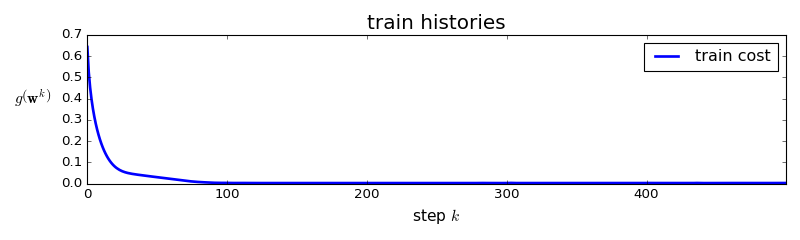

<IPython.core.display.Javascript object>


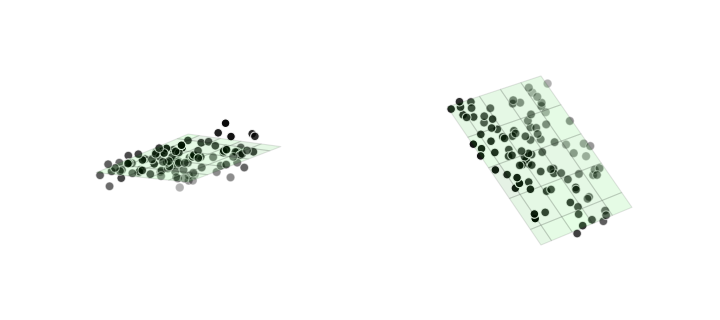

In [8]:
# build model for this dataset
lin_model = build_model(x_lin,y_lin,layer_sizes = [2],activation='linear')

# tune parameters of model
num_pts = x_lin.shape[1]
results = lin_model.fit(x=x_lin.T,y=y_lin.T,batch_size=num_pts, epochs=500,verbose = 0)

# plot cost function history plot
cost_history = results.history['loss']
plot_cost_history(cost_history,start = 0)

# find best set of weights based on lowest cost val
plot_regressions(x_lin,y_lin,lin_model)

# Build and fit NONLINEAR multi-output regression dataset

<IPython.core.display.Javascript object>


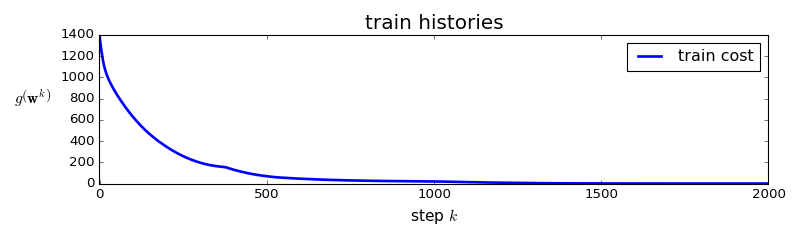

<IPython.core.display.Javascript object>


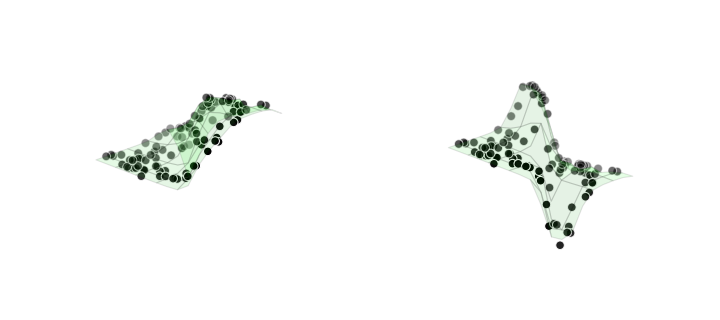

In [9]:
# build model for this dataset
nonlin_model = build_model(x_nonlin,y_nonlin,layer_sizes = [10,10],activation='tanh')

# tune parameters of model
num_pts = x_nonlin.shape[1]
results = nonlin_model.fit(x=x_nonlin.T,y=y_nonlin.T,batch_size=num_pts, epochs=2000,verbose = 0)

# plot cost function history plot
cost_history = results.history['loss']
plot_cost_history(cost_history,start = 0)

# find best set of weights based on lowest cost val
plot_regressions(x_nonlin,y_nonlin,nonlin_model)